In [1]:
!pip install openmim
!mim install mmdet

     |████████████████████████████████| 82 kB 135 kB/s eta 0:00:01
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=0baa01dc0f9f9238cc589df55c6a843aa9a3aaaf015b93955a256553480373e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
      Successfully uninstalled click-8.0.1
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpjjcx7jzb/mmdetection'...
remote: Enumerating objects: 24787, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24787 (delta 1), reused 5 (delta 0), pack-reused 24771
Receiving objects: 100% (24787/24787), 37.71 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (17364/17364), done.
Note: checking out '73b4e65a6a30435ef6a35f405e3474a4

In [4]:
from mmdet.apis import init_detector, inference_detector

config_file = 'train_config.py'
checkpoint_file ="work_dirs/train_config/latest.pth"
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)


load checkpoint from local path: work_dirs/train_config/latest.pth


In [5]:
len(model.CLASSES)

13

In [83]:
from glob import glob
from numpy.random import choice
imgs=glob('data/coco/test/*.jpg')
def random_show_inference(model):
# inference the demo image
    
    img=choice(imgs)
    result = inference_detector(model, img)
    list_contents=lambda rs: (model.CLASSES[rs[0]],list(rs[1][:,-1])) if len(rs[1])!=0 else None
    content=[_ for _ in map(list_contents,enumerate(result)) if _!=None]

    print(*content,sep="\n")
    model.show_result(img, result,
                      score_thr=0.2,
                      show=True,
                      text_color=(200, 200, 200),
                      font_size=32)

('black-bishop', [0.9934221, 0.99327505])
('black-king', [0.9979413])
('black-pawn', [0.9991391, 0.9969777])
('white-bishop', [0.99880505])
('white-king', [0.99317837])
('white-pawn', [0.9983901])


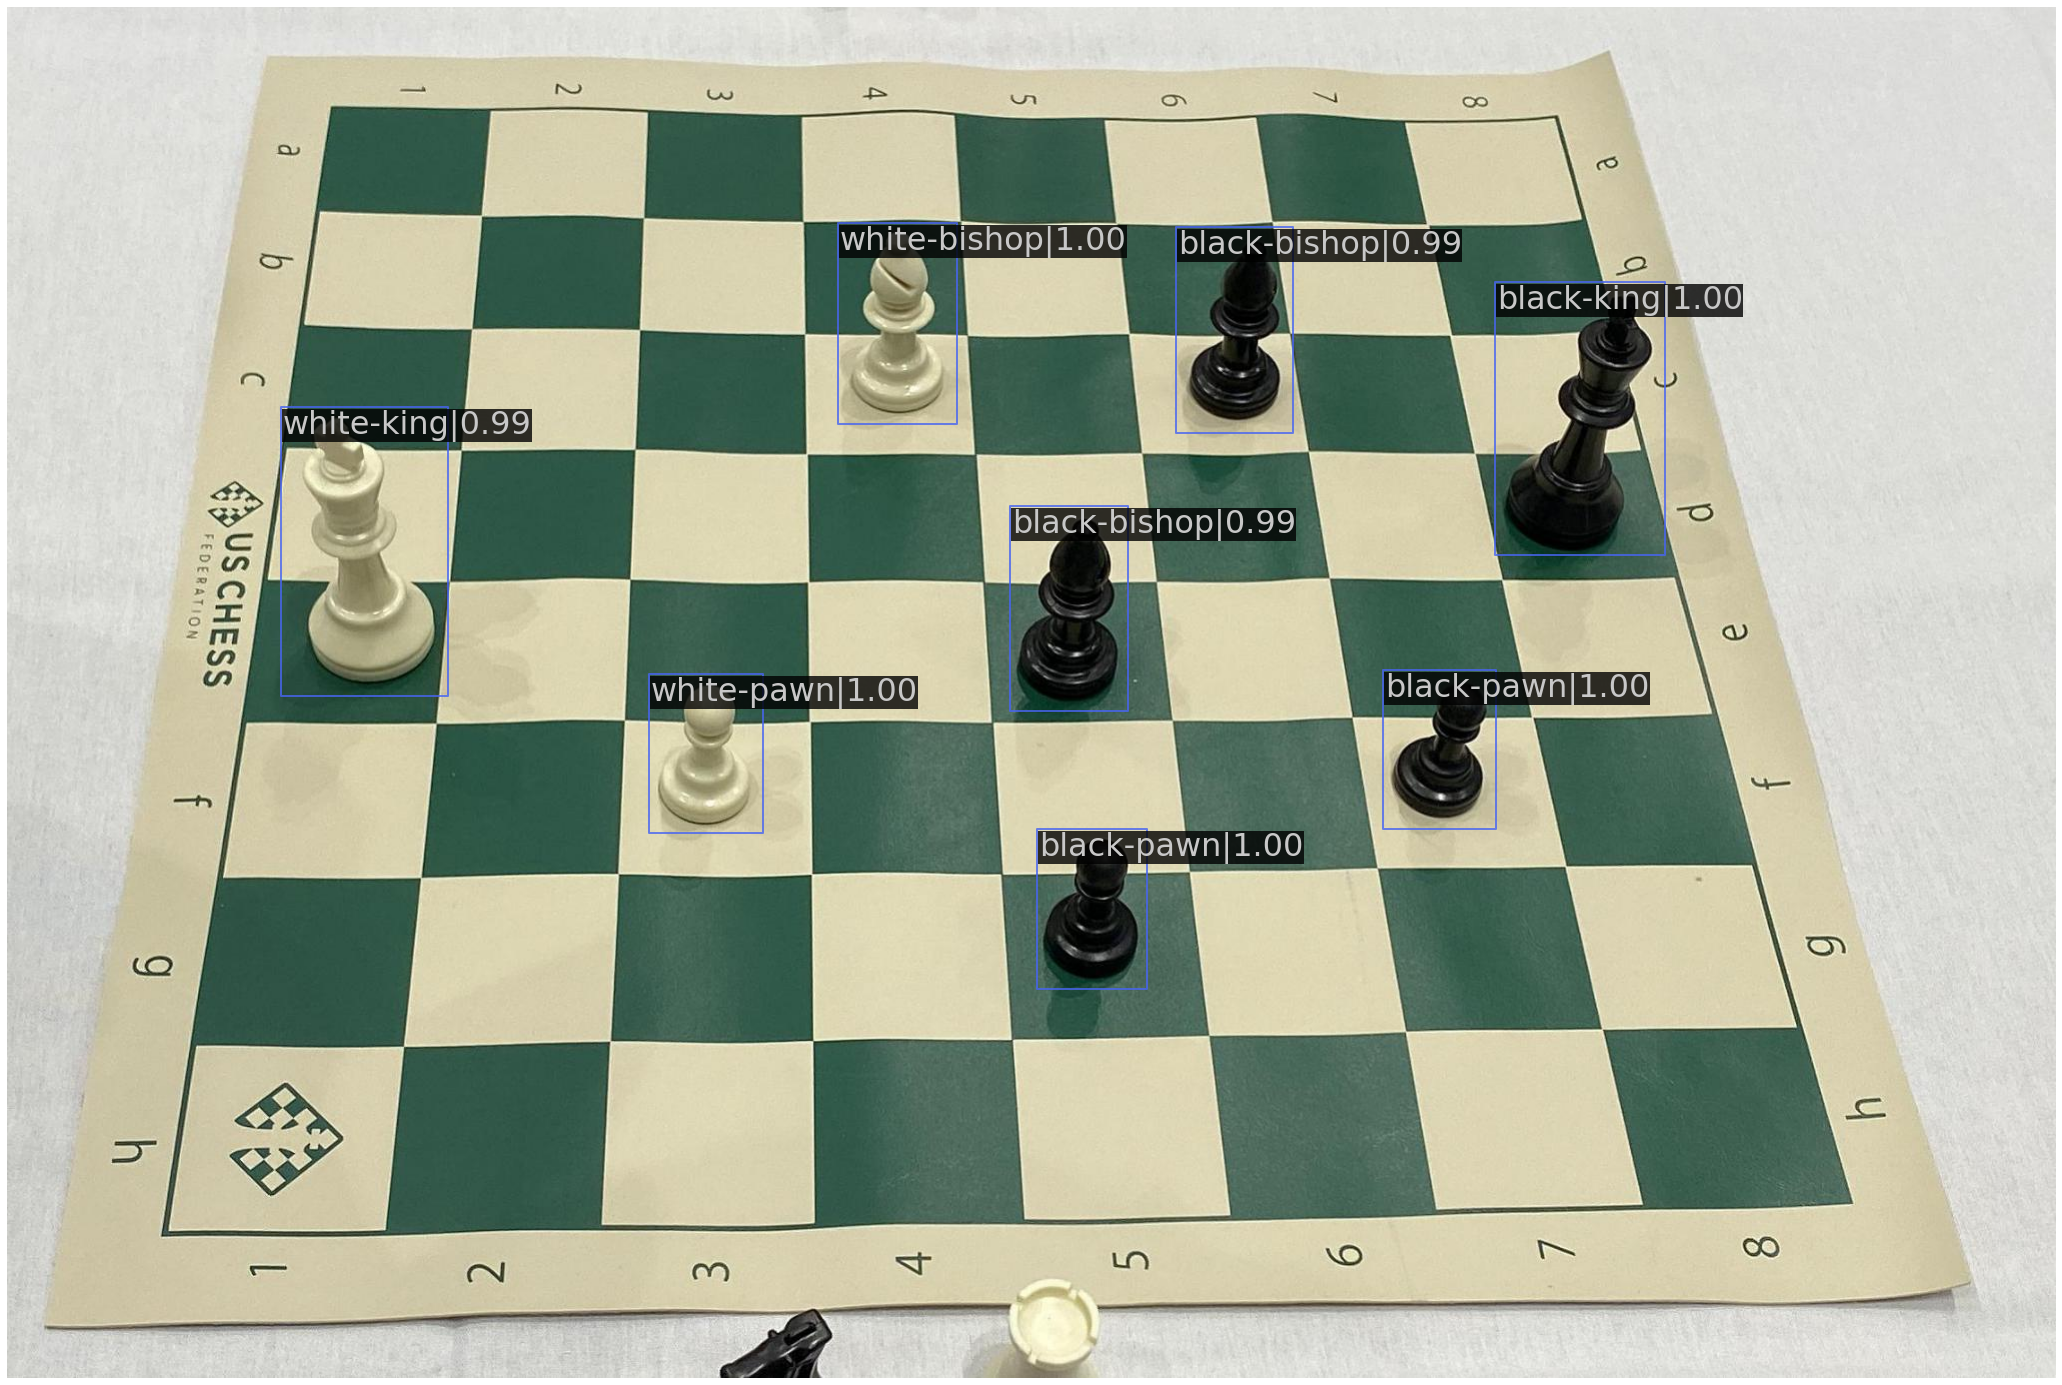

In [84]:
random_show_inference(model)